Ischaemic Images:
Number of Ischaemic samples: 1130


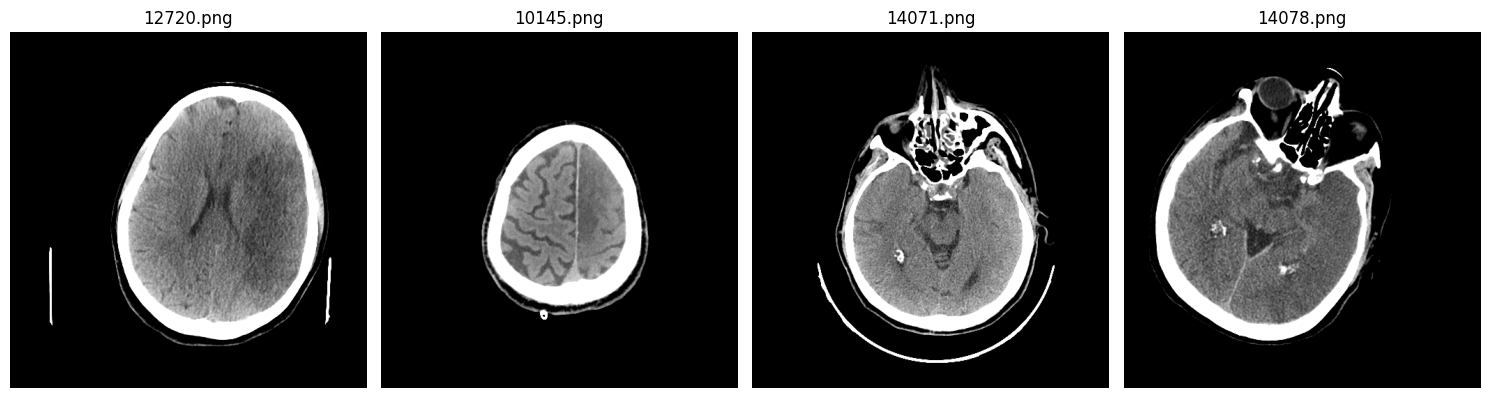

Non-Ischaemic Images:
Number of Non-Ischemic samples: 4427


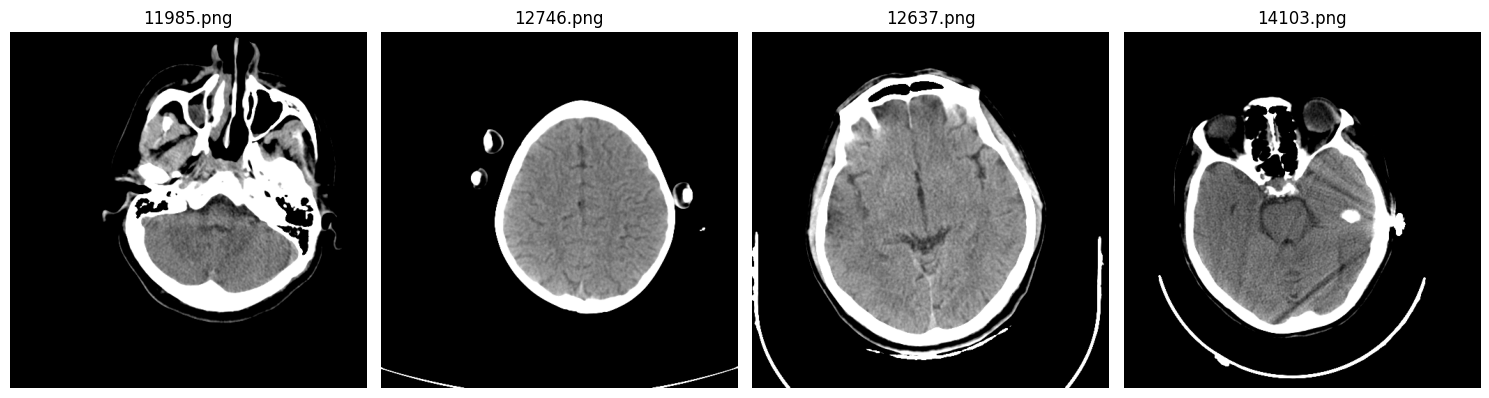

In [2]:
## ISCH-IRNet: ISCHemia detection using InceptionResNet.
# Cell 1: Display random images from the dataset
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

ischaemic_dir = "/home/vubuntu/Inv/Works/WORKKK/Train2/Ischaemic"
non_ischaemic_dir = "/home/vubuntu/Inv/Works/WORKKK/Train2/Non Ischaemic"

def display_random_images(directory, num_images=4):
    
    all_files = os.listdir(directory)
    # Filter out non-image files
    image_files = [f for f in all_files if f.lower().endswith(('.png'))]
    
    if not image_files:
        print(f"No image files found in {directory}")
        return

    random_files = random.sample(image_files, min(num_images, len(image_files)))

    # Create a figure and axes for the subplots
    fig, axes = plt.subplots(1, len(random_files), figsize=(15, 5))
    if len(random_files) == 1:
        axes = [axes]  

    # Display each image in a subplot
    for i, file in enumerate(random_files):
        image_path = os.path.join(directory, file)
        img = mpimg.imread(image_path)
        axes[i].imshow(img)
        axes[i].axis('off') 
        axes[i].set_title(os.path.basename(file)) 

    plt.tight_layout()
    plt.show()

print("Ischaemic Images:")
print(f"Number of Ischaemic samples: {len(os.listdir(ischaemic_dir))}")
display_random_images(ischaemic_dir)
print("Non-Ischaemic Images:")
print(f"Number of Non-Ischemic samples: {len(os.listdir(non_ischaemic_dir))}")
display_random_images(non_ischaemic_dir)

Number of ischaemic images: 1130
Number of non-ischaemic images: 4427
Random Images from Training Set:


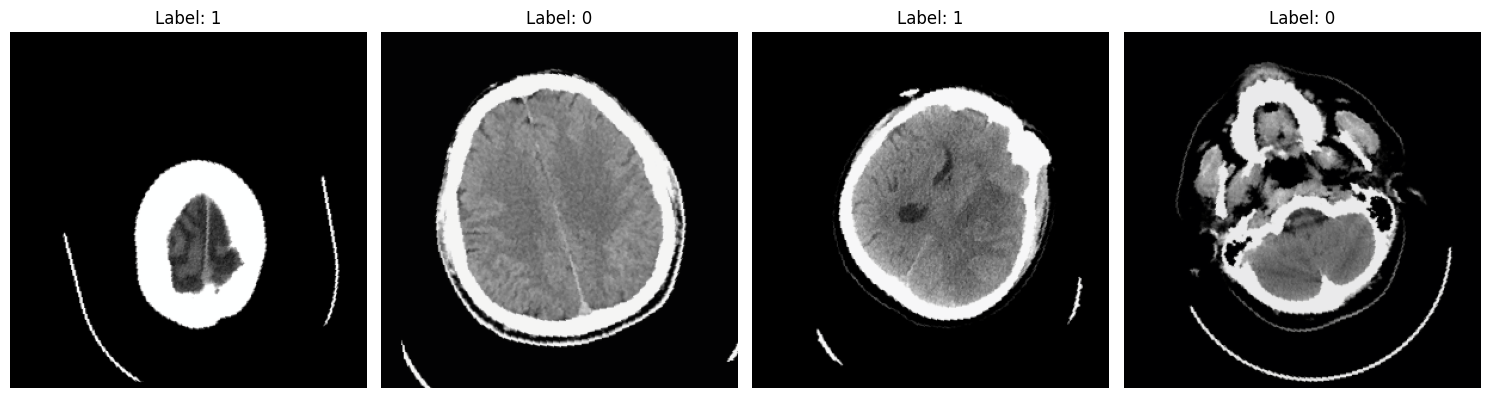

Shape of the first batch of images: torch.Size([32, 3, 299, 299])
Shape of the first batch of labels: torch.Size([32])
Number of train images: 6128
Number of validation images: 833
Number of test images: 835

Some Augmented Images:


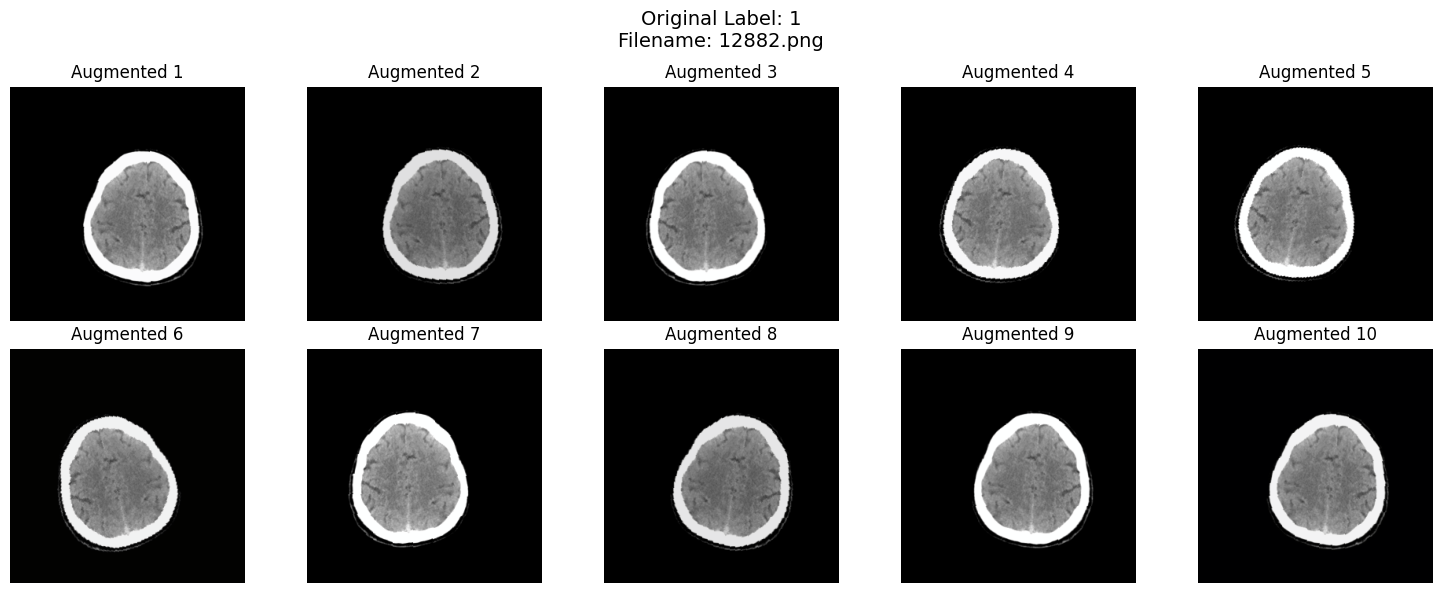

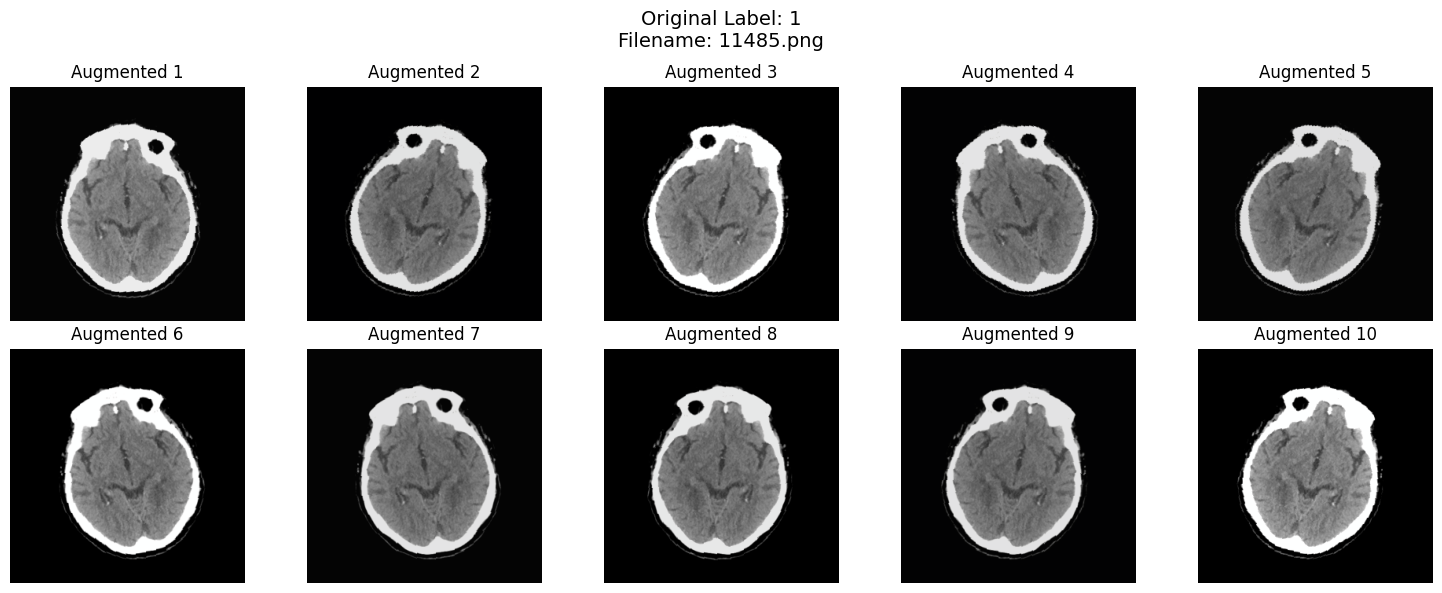

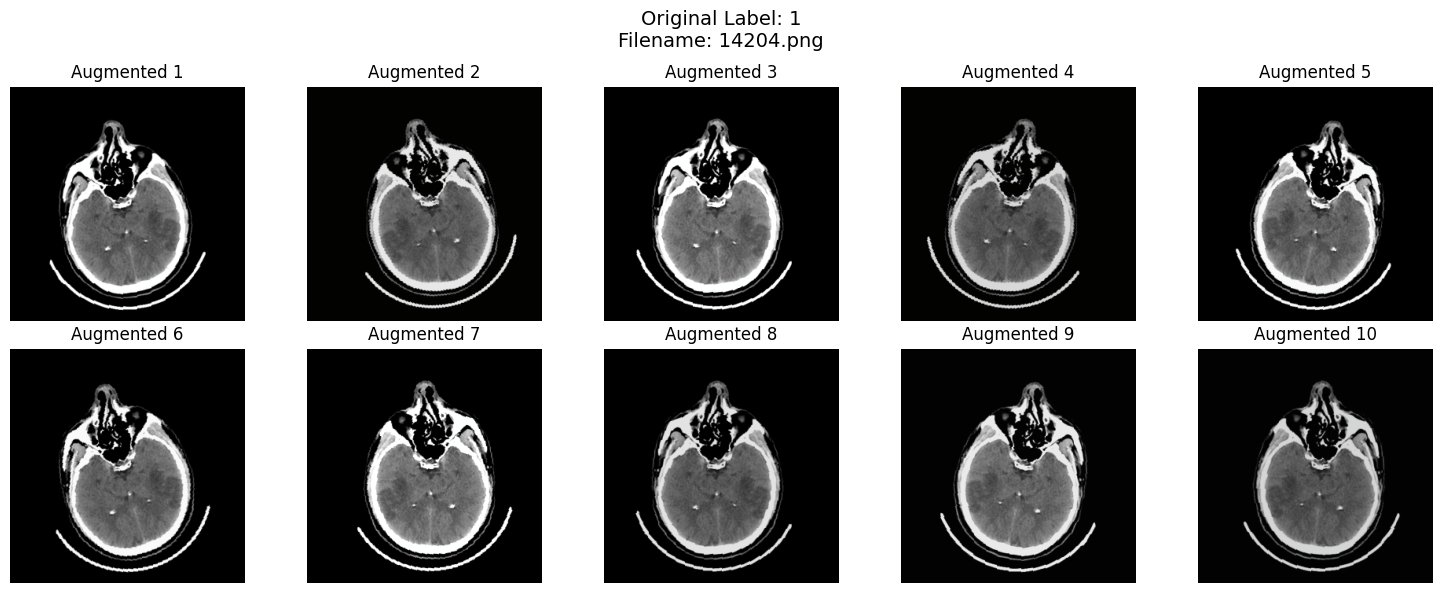

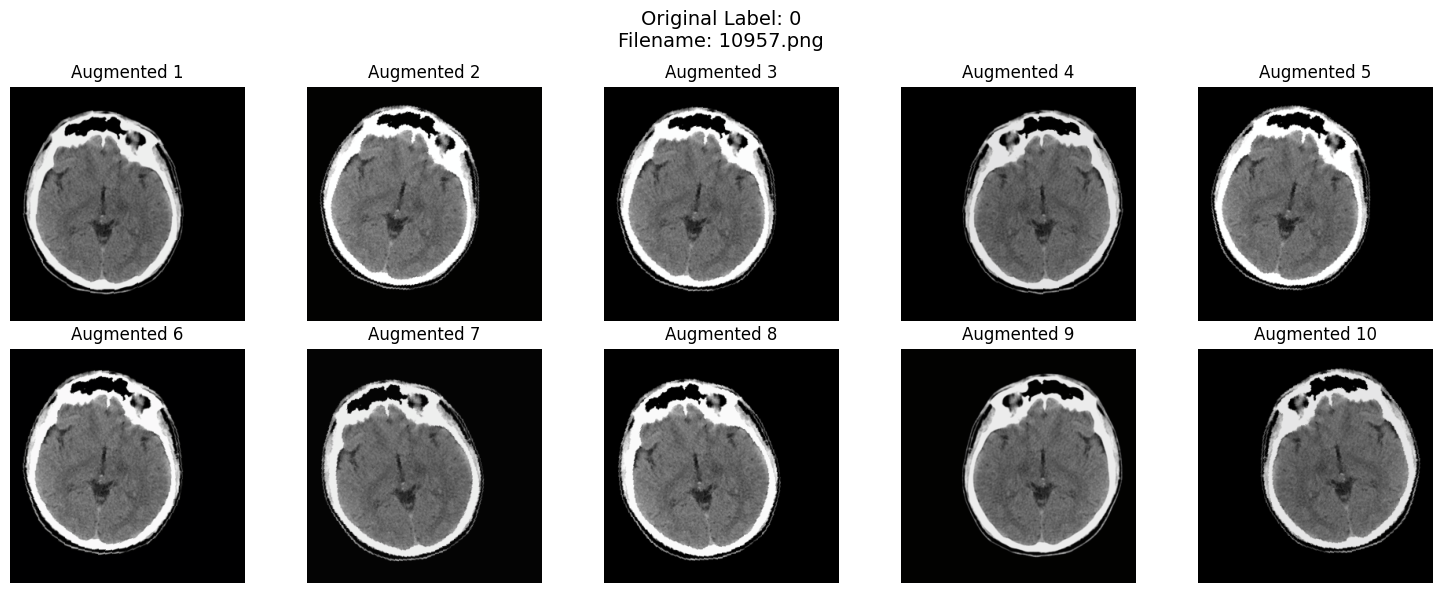

In [4]:
# Cell 2: Preparing the dataset for training
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import numpy as np

# Define image size for InceptionResNetV2
IMG_WIDTH = 299
IMG_HEIGHT = 299
BATCH_SIZE = 32

# Define the mean and std for normalization -ImageNet values-
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg'))]
        self.labels = [1 if image_dir == ischaemic_dir else 0] * len(self.image_paths) 
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB') 
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

# Define the transformations
train_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)), 
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15), 
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05), 
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

# Create datasets
ischaemic_dataset = ImageDataset(ischaemic_dir, transform=train_transform)
non_ischaemic_dataset = ImageDataset(non_ischaemic_dir, transform=train_transform)
all_dataset = torch.utils.data.ConcatDataset([ischaemic_dataset, non_ischaemic_dataset])

# Split the dataset into training, validation, and test sets
train_size = int(0.7 * len(all_dataset))
val_size = int(0.15 * len(all_dataset))
test_size = len(all_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(all_dataset, [train_size, val_size, test_size])

# --- Oversampling ---
# Separate majority and minority classes in the training set
train_indices = train_dataset.indices
ischaemic_indices = [i for i in train_indices if all_dataset[i][1] == 1]  
non_ischaemic_indices = [i for i in train_indices if all_dataset[i][1] == 0] 

# Oversample the minority class
num_ischaemic = len(ischaemic_indices)
num_non_ischaemic = len(non_ischaemic_indices)
oversampled_ischaemic_indices = random.choices(ischaemic_indices, k=num_non_ischaemic - num_ischaemic)

# Combine the original training set with the oversampled minority class
new_train_indices = train_indices + oversampled_ischaemic_indices
random.shuffle(new_train_indices)  # Shuffle the combined indices

# Create a new training dataset using the combined indices
train_dataset = torch.utils.data.Subset(all_dataset, new_train_indices)

# Create a dataset without transformations for displaying original images
original_dataset = torch.utils.data.ConcatDataset([
    ImageDataset(ischaemic_dir, transform=None),
    ImageDataset(non_ischaemic_dir, transform=None)
])

# Split the original dataset to match the indices of the train_dataset
original_train_dataset, _, _ = random_split(original_dataset, [train_size, val_size, test_size])
original_train_dataset.indices = train_dataset.indices

# Apply transforms to the datasets
# Note: We apply oversampling only to the training set. Validation and test sets remain unchanged.
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

# Create DataLoaders
# Note: Data augmentation is applied on-the-fly within the __getitem__ method of the ImageDataset class.
# This means each epoch will see slightly different versions of the images, effectively increasing the size of the dataset.
# The number of images reported by len(train_dataset) will reflect the original dataset size, not the augmented size.
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

num_ischaemic = len(ischaemic_dataset)
num_non_ischaemic = len(non_ischaemic_dataset)
print(f"Number of ischaemic images: {num_ischaemic}")
print(f"Number of non-ischaemic images: {num_non_ischaemic}")

def display_random_images_from_dataset(dataset, num_images=4):
    indices = random.sample(range(len(dataset)), min(num_images, len(dataset)))
    fig, axes = plt.subplots(1, len(indices), figsize=(15, 5))
    if len(indices) == 1:
        axes = [axes] 

    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        # The image is a tensor, so we move it to CPU, convert it to numpy, and transpose it
        image = image.cpu().numpy().transpose((1, 2, 0))
        # Denormalize the image
        image = image * np.array(STD) + np.array(MEAN)
        image = np.clip(image, 0, 1) # Clip values to [0, 1]
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(f"Label: {label}")

    plt.tight_layout()
    plt.show()

print("Random Images from Training Set:")
display_random_images_from_dataset(train_dataset)

for images, labels in train_loader:
    print("Shape of the first batch of images:", images.shape)
    print("Shape of the first batch of labels:", labels.shape)
    break

print(f"Number of train images: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")
print(f"Number of test images: {len(test_dataset)}")

def display_augmented_images(original_dataset, augmented_dataset, num_images=4):
    indices = random.sample(range(len(original_dataset)), min(num_images, len(original_dataset)))

    for i, idx in enumerate(indices):
        # Get the label from the original_dataset
        _, label = original_dataset[idx]

        # Access the underlying dataset to get the correct index
        full_dataset_idx = original_dataset.indices[idx]

        # Get the filename of the original image using the full dataset index
        # Determine which dataset (Ischaemic or Non-Ischaemic) the index belongs to
        if full_dataset_idx < len(original_dataset.dataset.datasets[0]):
            # Index belongs to the first dataset (Ischaemic)
            original_filename = original_dataset.dataset.datasets[0].image_paths[full_dataset_idx]
        else:
            # Index belongs to the second dataset (Non-Ischaemic)
            # Adjust the index to be relative to the second dataset
            adjusted_idx = full_dataset_idx - len(original_dataset.dataset.datasets[0])
            original_filename = original_dataset.dataset.datasets[1].image_paths[adjusted_idx]

        # Get 10 augmented images from the augmented_dataset
        augmented_images = []
        for _ in range(10):
            augmented_image, _ = augmented_dataset[idx]
            augmented_images.append(augmented_image)

        # Create a figure for the augmented images with a title for the filename and label
        fig_aug, axes_aug = plt.subplots(2, 5, figsize=(15, 6))
        fig_aug.suptitle(f"Original Label: {label}\nFilename: {os.path.basename(original_filename)}", fontsize=14)
        axes_aug = axes_aug.flatten()

        # Display the augmented images
        for j, augmented_image in enumerate(augmented_images):
            augmented_image_display = augmented_image.cpu().numpy().transpose((1, 2, 0))
            augmented_image_display = augmented_image_display * np.array(STD) + np.array(MEAN)
            augmented_image_display = np.clip(augmented_image_display, 0, 1)

            axes_aug[j].imshow(augmented_image_display)
            axes_aug[j].axis('off')
            axes_aug[j].set_title(f"Augmented {j+1}")

        plt.tight_layout()
        plt.show()

print("\nSome Augmented Images:")
display_augmented_images(original_train_dataset, train_dataset)

In [5]:
# Cell 3: Defining the model
import torch
import torch.nn as nn
import torch.optim as optim
from pytorchcv.model_provider import get_model

# Define constants 
NUM_CLASSES = 2
LEARNING_RATE = 0.001

# Load pre-trained InceptionResNetV2 model
model = get_model("inceptionresnetv2", pretrained=True)

# Freeze the parameters of the InceptionResNetV2 model
for param in model.parameters():
    param.requires_grad = False

# Remove the existing fully connected layer (output)
model.output = nn.Identity()

# Create a new fully connected network
model.my_fc = nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=(1, 1)),
    nn.Flatten(),
    nn.Linear(in_features=1536, out_features=1024), 
    nn.BatchNorm1d(num_features=1024),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.3), 
    nn.Linear(in_features=1024, out_features=1), 
    nn.Sigmoid() 
)

# Unfreeze the later layers 
unfreeze_from = 8  # Unfreeze from the 8th block onwards
for i, child in enumerate(model.children()):
    if i >= unfreeze_from:
        for param in child.parameters():
            param.requires_grad = True

# Calculate class weights for the positive class
total_samples = num_ischaemic + num_non_ischaemic
weight_positive = num_non_ischaemic / num_ischaemic  # Weight for the positive class (Ischaemic)
class_weights = torch.tensor([weight_positive], dtype=torch.float)

# Move class_weights to the same device as the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = class_weights.to(device)

# Define loss function and optimizer
# Use Focal Loss for class imbalance
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

# Adjust class weights if necessary
criterion = FocalLoss(alpha=weight_positive, gamma=2) 

# Optional: Use different learning rates for different layers
optimizer = optim.Adam([
    {'params': model.features.parameters(), 'lr': 1e-5},  # # Smaller LR for pre-trained layers to preserve learned features
    {'params': model.my_fc.parameters(), 'lr': 1e-3}  # Larger LR for new layers to learn task-specific features.
], weight_decay=1e-4) 

print(f"Class weights: {class_weights}\n")

print(model)

Class weights: tensor([3.9177], device='cuda:0')

InceptionResNetV2(
  (features): Sequential(
    (init_block): InceptInitBlock(
      (conv1): ConvBlock(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (activ): ReLU(inplace=True)
      )
      (conv2): ConvBlock(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (activ): ReLU(inplace=True)
      )
      (conv3): ConvBlock(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (activ): ReLU(inplace=True)
      )
      (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv4): ConvBlock(
        (conv

/home/vubuntu/Inv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/25: 100%|██████████| 194/194 [01:28<00:00,  2.20it/s, loss=0.568, accuracy=68.9]


Epoch 1/25, Ischaemic Loss: 0.0501, Non-Ischaemic Loss: 0.0231
Epoch 1/25, Train Loss: 0.5887, Train Accuracy: 68.93%, Val Loss: 0.6733, Val Accuracy: 84.15%


Epoch 2/25: 100%|██████████| 194/194 [01:26<00:00,  2.25it/s, loss=0.459, accuracy=75.5]


Epoch 2/25, Ischaemic Loss: 0.0486, Non-Ischaemic Loss: 0.0194
Epoch 2/25, Train Loss: 0.5475, Train Accuracy: 75.54%, Val Loss: 0.6930, Val Accuracy: 84.51%


Epoch 3/25: 100%|██████████| 194/194 [01:29<00:00,  2.16it/s, loss=0.477, accuracy=77.4]


Epoch 3/25, Ischaemic Loss: 0.0485, Non-Ischaemic Loss: 0.0180
Epoch 3/25, Train Loss: 0.5376, Train Accuracy: 77.41%, Val Loss: 0.6770, Val Accuracy: 87.03%


Epoch 4/25: 100%|██████████| 194/194 [01:30<00:00,  2.14it/s, loss=0.487, accuracy=78.4]


Epoch 4/25, Ischaemic Loss: 0.0478, Non-Ischaemic Loss: 0.0176
Epoch 4/25, Train Loss: 0.5274, Train Accuracy: 78.36%, Val Loss: 0.7312, Val Accuracy: 86.31%


Epoch 5/25: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, loss=0.556, accuracy=79.6]


Epoch 5/25, Ischaemic Loss: 0.0480, Non-Ischaemic Loss: 0.0167
Epoch 5/25, Train Loss: 0.5230, Train Accuracy: 79.55%, Val Loss: 0.6725, Val Accuracy: 87.15%


Epoch 6/25: 100%|██████████| 194/194 [01:36<00:00,  2.01it/s, loss=0.503, accuracy=80.6]


Epoch 6/25, Ischaemic Loss: 0.0479, Non-Ischaemic Loss: 0.0162
Epoch 6/25, Train Loss: 0.5169, Train Accuracy: 80.60%, Val Loss: 0.6683, Val Accuracy: 87.88%


Epoch 7/25: 100%|██████████| 194/194 [01:40<00:00,  1.93it/s, loss=0.533, accuracy=80.9]


Epoch 7/25, Ischaemic Loss: 0.0472, Non-Ischaemic Loss: 0.0164
Epoch 7/25, Train Loss: 0.5127, Train Accuracy: 80.86%, Val Loss: 0.6654, Val Accuracy: 88.48%


Epoch 8/25: 100%|██████████| 194/194 [01:51<00:00,  1.74it/s, loss=0.408, accuracy=81]  


Epoch 8/25, Ischaemic Loss: 0.0476, Non-Ischaemic Loss: 0.0157
Epoch 8/25, Train Loss: 0.5114, Train Accuracy: 80.97%, Val Loss: 0.6780, Val Accuracy: 87.64%


Epoch 9/25: 100%|██████████| 194/194 [01:55<00:00,  1.69it/s, loss=0.411, accuracy=81.7]


Epoch 9/25, Ischaemic Loss: 0.0472, Non-Ischaemic Loss: 0.0158
Epoch 9/25, Train Loss: 0.5083, Train Accuracy: 81.72%, Val Loss: 0.6638, Val Accuracy: 86.55%


Epoch 10/25: 100%|██████████| 194/194 [01:55<00:00,  1.68it/s, loss=0.566, accuracy=82.7]


Epoch 10/25, Ischaemic Loss: 0.0476, Non-Ischaemic Loss: 0.0152
Epoch 10/25, Train Loss: 0.5062, Train Accuracy: 82.68%, Val Loss: 0.6693, Val Accuracy: 87.03%


Epoch 11/25: 100%|██████████| 194/194 [01:48<00:00,  1.79it/s, loss=0.478, accuracy=83.1]


Epoch 11/25, Ischaemic Loss: 0.0468, Non-Ischaemic Loss: 0.0151
Epoch 11/25, Train Loss: 0.5002, Train Accuracy: 83.12%, Val Loss: 0.6676, Val Accuracy: 88.60%


Epoch 12/25: 100%|██████████| 194/194 [01:54<00:00,  1.69it/s, loss=0.461, accuracy=83.3]


Epoch 12/25, Ischaemic Loss: 0.0468, Non-Ischaemic Loss: 0.0149
Epoch 12/25, Train Loss: 0.4996, Train Accuracy: 83.34%, Val Loss: 0.6658, Val Accuracy: 87.64%


Epoch 13/25: 100%|██████████| 194/194 [01:56<00:00,  1.67it/s, loss=0.465, accuracy=83.2]


Epoch 13/25, Ischaemic Loss: 0.0470, Non-Ischaemic Loss: 0.0150
Epoch 13/25, Train Loss: 0.5004, Train Accuracy: 83.20%, Val Loss: 0.6641, Val Accuracy: 89.44%


Epoch 14/25: 100%|██████████| 194/194 [01:57<00:00,  1.65it/s, loss=0.479, accuracy=84.3]


Epoch 14/25, Ischaemic Loss: 0.0463, Non-Ischaemic Loss: 0.0145
Epoch 14/25, Train Loss: 0.4914, Train Accuracy: 84.31%, Val Loss: 0.6534, Val Accuracy: 89.20%


Epoch 15/25: 100%|██████████| 194/194 [01:45<00:00,  1.84it/s, loss=0.487, accuracy=86]  


Epoch 15/25, Ischaemic Loss: 0.0465, Non-Ischaemic Loss: 0.0133
Epoch 15/25, Train Loss: 0.4833, Train Accuracy: 85.99%, Val Loss: 0.6792, Val Accuracy: 87.76%


Epoch 16/25: 100%|██████████| 194/194 [02:05<00:00,  1.55it/s, loss=0.492, accuracy=85.6]


Epoch 16/25, Ischaemic Loss: 0.0465, Non-Ischaemic Loss: 0.0133
Epoch 16/25, Train Loss: 0.4827, Train Accuracy: 85.62%, Val Loss: 0.6959, Val Accuracy: 87.88%


Epoch 17/25: 100%|██████████| 194/194 [01:54<00:00,  1.70it/s, loss=0.643, accuracy=86.3]


Epoch 17/25, Ischaemic Loss: 0.0460, Non-Ischaemic Loss: 0.0131
Epoch 17/25, Train Loss: 0.4772, Train Accuracy: 86.34%, Val Loss: 0.6458, Val Accuracy: 90.04%


Epoch 18/25: 100%|██████████| 194/194 [01:53<00:00,  1.72it/s, loss=0.58, accuracy=87]   


Epoch 18/25, Ischaemic Loss: 0.0465, Non-Ischaemic Loss: 0.0128
Epoch 18/25, Train Loss: 0.4783, Train Accuracy: 86.99%, Val Loss: 0.6487, Val Accuracy: 90.16%


Epoch 19/25: 100%|██████████| 194/194 [01:51<00:00,  1.74it/s, loss=0.494, accuracy=87.3]


Epoch 19/25, Ischaemic Loss: 0.0460, Non-Ischaemic Loss: 0.0127
Epoch 19/25, Train Loss: 0.4732, Train Accuracy: 87.31%, Val Loss: 0.6445, Val Accuracy: 89.32%


Epoch 20/25: 100%|██████████| 194/194 [01:52<00:00,  1.73it/s, loss=0.559, accuracy=87.9]


Epoch 20/25, Ischaemic Loss: 0.0462, Non-Ischaemic Loss: 0.0123
Epoch 20/25, Train Loss: 0.4724, Train Accuracy: 87.87%, Val Loss: 0.6815, Val Accuracy: 89.68%


Epoch 21/25: 100%|██████████| 194/194 [01:48<00:00,  1.80it/s, loss=0.384, accuracy=87.7]


Epoch 21/25, Ischaemic Loss: 0.0462, Non-Ischaemic Loss: 0.0125
Epoch 21/25, Train Loss: 0.4734, Train Accuracy: 87.68%, Val Loss: 0.6509, Val Accuracy: 90.04%


Epoch 22/25: 100%|██████████| 194/194 [01:48<00:00,  1.79it/s, loss=0.468, accuracy=88.1]


Epoch 22/25, Ischaemic Loss: 0.0460, Non-Ischaemic Loss: 0.0121
Epoch 22/25, Train Loss: 0.4681, Train Accuracy: 88.07%, Val Loss: 0.6465, Val Accuracy: 89.56%


Epoch 23/25: 100%|██████████| 194/194 [01:49<00:00,  1.77it/s, loss=0.454, accuracy=87.8]


Epoch 23/25, Ischaemic Loss: 0.0461, Non-Ischaemic Loss: 0.0123
Epoch 23/25, Train Loss: 0.4720, Train Accuracy: 87.76%, Val Loss: 0.6591, Val Accuracy: 89.68%


Epoch 24/25: 100%|██████████| 194/194 [01:50<00:00,  1.76it/s, loss=0.445, accuracy=88.4]


Epoch 24/25, Ischaemic Loss: 0.0459, Non-Ischaemic Loss: 0.0120
Epoch 24/25, Train Loss: 0.4675, Train Accuracy: 88.37%, Val Loss: 0.6403, Val Accuracy: 91.36%


Epoch 25/25: 100%|██████████| 194/194 [01:47<00:00,  1.80it/s, loss=0.408, accuracy=87.4]


Epoch 25/25, Ischaemic Loss: 0.0458, Non-Ischaemic Loss: 0.0124
Epoch 25/25, Train Loss: 0.4708, Train Accuracy: 87.41%, Val Loss: 0.6541, Val Accuracy: 90.64%


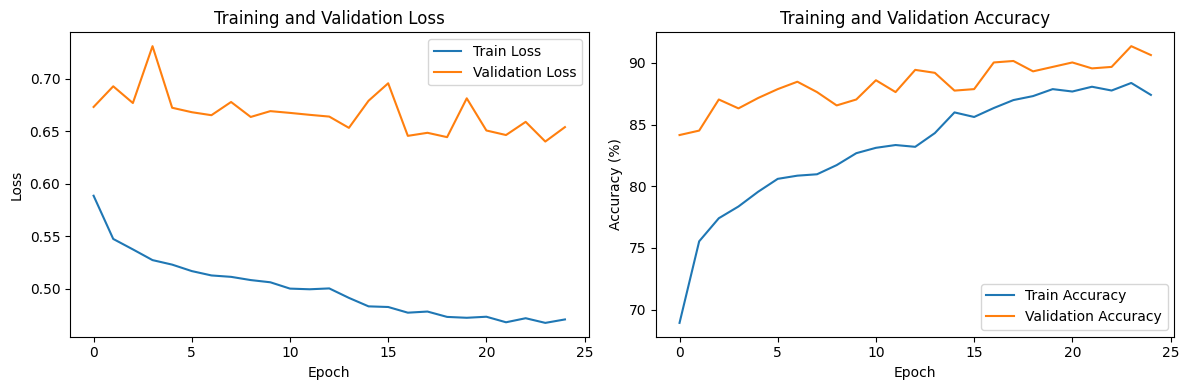

In [7]:
# Cell 4: Training the model
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

# Define constants
NUM_EPOCHS = 25  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize optimizer 
optimizer = optim.Adam([
    {'params': model.features.parameters(), 'lr': 1e-5},
    {'params': model.my_fc.parameters(), 'lr': 1e-3}
], weight_decay=1e-4)

# Define the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, verbose=True)

# Initialize variables for early stopping
best_val_loss = float('inf')
epochs_without_improvement = 0
patience = 5

# Initialize lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
for epoch in range(NUM_EPOCHS):
    model.train()  # Set the model to training mode
    train_loss = 0.0
    train_correct = 0
    total_train = 0
    epoch_class_losses = [0.0, 0.0]  # Initialize class losses for the epoch
    class_sample_counts = [0, 0]  # Initialize sample counts for each class
    progress_bar = tqdm(
        enumerate(train_loader),
        total=len(train_loader),
        desc=f"Epoch {epoch + 1}/{NUM_EPOCHS}",
    )
    for i, (images, labels) in progress_bar:
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients to prevent accumulation from previous iterations.
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        outputs = outputs.view(outputs.size(0), -1, 1, 1)
        outputs = model.my_fc(outputs)

        # Calculate the loss
        loss = criterion(outputs, labels.float().unsqueeze(1))

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        predicted = (outputs > 0.5).int()
        total_train += labels.size(0)
        train_correct += (predicted == labels.unsqueeze(1)).sum().item()
        progress_bar.set_postfix(
            {"loss": loss.item(), "accuracy": 100 * train_correct / total_train}
        )

        # Calculate and accumulate class-wise loss
        for class_label in range(NUM_CLASSES):
            class_indices = labels == class_label
            if class_indices.any():
                class_outputs = outputs[class_indices]
                class_labels = labels[class_indices].float().unsqueeze(1)
                class_loss = criterion(class_outputs, class_labels)
                epoch_class_losses[class_label] += class_loss.item()
                class_sample_counts[class_label] += class_labels.size(0)

    # Calculate average class losses for the epoch
    avg_class_losses = [
        epoch_class_losses[i] / class_sample_counts[i]
        if class_sample_counts[i] > 0
        else 0
        for i in range(NUM_CLASSES)
    ]

    print(
        f"Epoch {epoch+1}/{NUM_EPOCHS}, Ischaemic Loss: {avg_class_losses[0]:.4f}, Non-Ischaemic Loss: {avg_class_losses[1]:.4f}"
    )

    # Validation step
    model.eval()
    val_loss = 0.0
    val_correct = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            outputs = outputs.view(outputs.size(0), -1, 1, 1)
            outputs = model.my_fc(outputs)
            loss = criterion(outputs, labels.float().unsqueeze(1))
            val_loss += loss.item()
            predicted = (outputs > 0.5).int()
            total_val += labels.size(0)
            val_correct += (predicted == labels.unsqueeze(1)).sum().item()

    # Early stopping check
    if val_loss / len(val_loader) < best_val_loss:
        best_val_loss = val_loss / len(val_loader)
        epochs_without_improvement = 0
        # Save the best model so far
        torch.save(model.state_dict(), "isch-inceptionresnetv2.pth")
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after epoch {epoch+1}")
            break

    train_accuracy = 100 * train_correct / total_train
    val_accuracy = 100 * val_correct / total_val
    print(
        f"Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {train_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss/len(val_loader):.4f}, Val Accuracy: {val_accuracy:.2f}%"
    )

    # Step the scheduler
    scheduler.step(val_loss / len(val_loader))

    # Store metrics
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

# Plot training and validation metrics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

/tmp/ipykernel_48607/593445856.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Test Accuracy: 0.8910
Test Precision: 0.8854
Test Recall: 0.8910
Test F1-Score: 0.8829
Test AUC: 0.7630


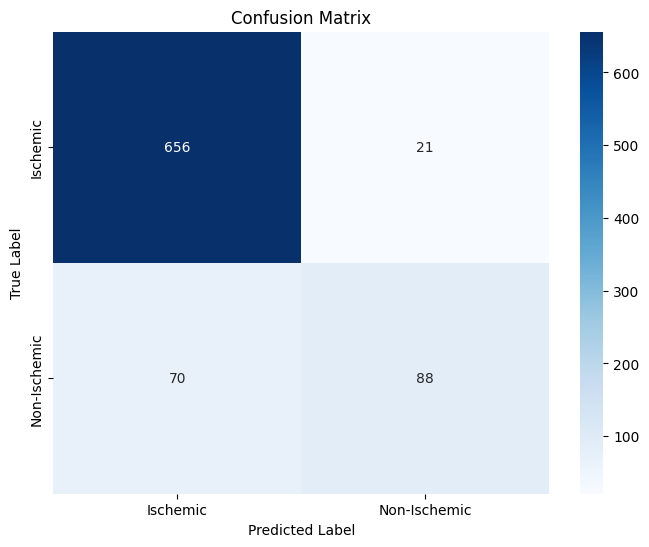

In [7]:
# Cell 5: Evaluating the model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model_path = "/home/vubuntu/Inv/Works/WORKKK/isch-inceptionresnetv2.pth"
NUM_CLASSES = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained InceptionResNetV2 model without weights
model = get_model("inceptionresnetv2", pretrained=False)

# Remove the existing fully connected layer (output)
model.output = nn.Identity()

# Create a new fully connected network
model.my_fc = nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=(1, 1)),
    nn.Flatten(),
    nn.Linear(in_features=1536, out_features=1024),  # Assuming input to FC is 1536
    nn.BatchNorm1d(num_features=1024),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=1024, out_features=1), # Output layer for binary classification
    nn.Sigmoid() # Sigmoid activation for binary classification
)

# Load the saved state dictionary 
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

# Initialize lists to store predictions and true labels
all_preds = []
all_labels = []

# Evaluate the model on the test set
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        # Reshape outputs to add spatial dimensions for AdaptiveAvgPool2d
        outputs = outputs.view(outputs.size(0), -1, 1, 1)  # Add spatial dimensions (height and width)
        outputs = model.my_fc(outputs)
        # Get predictions
        predicted = (outputs > 0.5).int()
        all_preds.extend(predicted.cpu().numpy().flatten()) # Flatten the predictions
        all_labels.extend(labels.cpu().numpy())
        
# Calculate evaluation metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

try:
    auc = roc_auc_score(all_labels, all_preds, average='weighted', multi_class='ovr')
except ValueError:
    auc = np.nan

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")
print(f"Test AUC: {auc:.4f}")

# Plot the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Ischemic', 'Non-Ischemic'], yticklabels=['Ischemic', 'Non-Ischemic'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [9]:
# Cell 6: Predicting on an Input Image
from PIL import Image

def predict_image(image_path, model, transform, device):
    """
    Predicts whether an image is ischemic or non-ischemic.

    Args:
        image_path: Path to the image file (PNG or JPG).
        model: The trained PyTorch model.
        transform: The transformation to apply to the image.
        device: The device to run the prediction on (CPU or CUDA).

    Returns:
        A tuple containing the prediction (1 for ischemic, 0 for non-ischemic) and the probability.
    """
    try:
        # Load and preprocess the image
        image = Image.open(image_path).convert('RGB')
    except FileNotFoundError:
        print(f"Error: Image not found at {image_path}")
        return None, None
    except Exception as e:
        print(f"Error: Could not open image. {e}")
        return None, None

    image = transform(image).unsqueeze(0).to(device)

    # Make the prediction
    model.eval()
    with torch.no_grad():
        output = model(image)
        output = output.view(output.size(0), -1, 1, 1)
        output = model.my_fc(output)
        probability = output.item()
        prediction = 1 if probability > 0.5 else 0

    return prediction, probability

# Define the transformation for the input image (SAME AS USED IN VALIDATION)
input_transform = val_test_transform

# Get the image path from the user
image_path = input("Enter the path to the image: ")

# Make the prediction
prediction, probability = predict_image(image_path, model, input_transform, device)

# Print the results
if prediction is not None:  # Check if prediction was successful
    if prediction == 1:
        print(f"The image is predicted to be ISCHEMIC with a probability of {probability:.4f}")
    else:
        print(f"The image is predicted to be NON-ISCHEMIC with a probability of {1-probability:.4f}")

The image is predicted to be NON-ISCHEMIC with a probability of 0.8341
